In [370]:
import os
import time
import torch
import torch.onnx
import torch.cuda
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [371]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [372]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding = 2),
            nn.BatchNorm2d(num_features=6),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(num_features=16),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            #nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            #nn.BatchNorm2d(num_features=120),
            #nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.Sigmoid(),
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=n_classes),
            nn.Softmax(dim = 1),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        #print(x.dim)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [373]:
def get_accuracy(get_model, data_loader, device):
    correct_pred = 0
    n = 0

    with torch.no_grad():
        get_model.eval()
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            y_prob = get_model(inputs)
            _, predicted_labels = torch.max(y_prob, 1)

            n += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float() / n

In [374]:
def plot_losses(train_losses, valid_losses):
    plt.style.use('default')
    train_losses = np.array(torch.stack(train_losses).to('cpu'))
    valid_losses = np.array(torch.stack(valid_losses).to('cpu'))

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, label='Training loss')
    ax.plot(valid_losses, label='Validation loss')
    ax.set(title="Loss/pochs",
           xlabel='Epoch',
           ylabel='Loss')
    plt.xticks(np.arange(0, epochs))
    ax.legend()
    fig.show()


In [375]:
def plot_accuracy(train_acc, valid_acc):
    plt.style.use('default')
    train_acc = np.array(torch.stack(train_acc).to('cpu'))
    valid_acc = np.array(torch.stack(valid_acc).to('cpu'))

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, label='Training accuracy')
    ax.plot(valid_acc, label='Validation accuracy')
    ax.set(title="Accuracy/epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    ax.legend()
    plt.xticks(np.arange(0, epochs))
    fig.show()


In [376]:
def train(train_data, get_model, get_criterion, get_optimizer, size, device):
    training_loss = 0
    get_model.train()

    for inputs, labels in train_data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        get_optimizer.zero_grad()
        outputs = get_model(inputs)
        loss = get_criterion(outputs, labels)

        loss.backward()
        get_optimizer.step()

        training_loss += loss.data * inputs.shape[0]

    epoch_loss = training_loss / size["train"]

    return get_model, get_optimizer, epoch_loss

In [377]:
def valid(test_data, get_model, get_criterion, get_optimizer, size, device):
    valid_loss = 0
    get_model.eval()

    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = get_model(inputs)

        get_optimizer.zero_grad()
        loss = get_criterion(outputs, labels)

        valid_loss += loss.data * inputs.shape[0]

    epoch_valid_loss = valid_loss / size["test"]

    return get_model, get_optimizer, epoch_valid_loss

In [378]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

In [379]:
def train_loop(model, criterion, optimizer, num_epochs, dataloaders, dataset_sizes, device, first_epoch=1):
    since = time.time()
    
    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('\nepoch', epoch)

        model, optimizer, train_loss = train(dataloaders[0], model, criterion, optimizer, dataset_sizes, device)
        train_losses.append(train_loss)

        train_acc = get_accuracy(model, dataloaders[0], device=device)
        train_accuracy.append(train_acc*100)
        print('Training loss:{:.4f}'.format(train_loss.item()))
        print("Training accuracy:{:.2f}".format(train_acc.item()*100))

        with torch.no_grad():
            model, optimizer, valid_loss = valid(dataloaders[-1], model, criterion, optimizer, dataset_sizes, device)
            valid_losses.append(valid_loss)

            valid_acc = get_accuracy(model, dataloaders[-1], device=device)
            valid_accuracy.append(valid_acc*100)
            print('\nValidation loss:{:.4f}'.format(valid_loss.item()))
            print("Validation accuracy:{:.2f}".format(valid_acc.item()*100))

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    plot_losses(train_losses, valid_losses)
    plot_accuracy(train_accuracy, valid_accuracy)

    return model

In [380]:
def test_accuracy(loader, get_model, train_state):
    num_correct = num_samples = 0
    get_model.eval()
    with torch.no_grad():
        for data in loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = get_model(inputs)
            _, preds = outputs.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
    accuracy = (num_correct.item() / num_samples) * 100
    if train_state:
        print("Model Predicted {} correctly out of {} from training dataset, "
              "Accuracy: {:.2f}".format(num_correct.item(), num_samples, accuracy))
    else:
        print("Model Predicted {} correctly out of {} from testing dataset, Accuracy: {:.2f}".format(num_correct.item(), num_samples, accuracy))
        get_model.train()


In [381]:
def top_errors(loader, model):
    model.eval()
    inp = 0
    errors = []
    for data in loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = outputs.max(1)
        values = (preds == labels).data.cpu().numpy()
        values = np.where(values == False)[0]
        if len(values) > 0:
            error = []

            pred_value = outputs[values].data.cpu().numpy().flatten()[preds[values].data.cpu().numpy()]
            lable_value = outputs[values].data.cpu().numpy().flatten()[labels[values].data.cpu().numpy()]
            error_value = abs(pred_value - lable_value)

            for i in range(len(values)):
                error.append(preds[values[i]].data.cpu().numpy())
                error.append(labels[values[i]].data.cpu().numpy())
                error.append(error_value[i])

                img = inputs[values[i]].data.cpu().resize_(28,28)
                error.append(img)

            errors.append(error)

    for error in sorted(errors,key=lambda x: x[2], reverse=True)[:10]:
        print('predicted:', error[0])
        print('real:', error[1])
        print('abs error:', error[2])
        plt.imshow(error[3])
        plt.show()

In [382]:
root = './data'
if not os.path.exists(root): os.mkdir(root)
    
batch_size = 50
epochs = 10
n_classes = 10
learning_rate = 0.002

def_trans = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=root, train=True, transform=def_trans, download=True)
test_dataset = datasets.MNIST(root=root, train=False, transform=def_trans, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
dataset_sizes = {'train':len(train_dataset), 'test':len(test_dataset)}

print("device: ", device)

device:  cuda


In [383]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )



epoch 1
Training loss:1.6884
Training accuracy:95.83

Validation loss:1.5040
Validation accuracy:96.26

epoch 2
Training loss:1.5048
Training accuracy:97.05

Validation loss:1.4914
Validation accuracy:97.19

epoch 3
Training loss:1.4942
Training accuracy:97.15

Validation loss:1.4856
Validation accuracy:97.68

epoch 4
Training loss:1.4885
Training accuracy:97.93

Validation loss:1.4814
Validation accuracy:98.12

epoch 5
Training loss:1.4852
Training accuracy:97.16

Validation loss:1.4887
Validation accuracy:97.36

epoch 6
Training loss:1.4825
Training accuracy:98.00

Validation loss:1.4799
Validation accuracy:98.17

epoch 7
Training loss:1.4795
Training accuracy:98.44

Validation loss:1.4788
Validation accuracy:98.32

epoch 8
Training loss:1.4783
Training accuracy:98.47

Validation loss:1.4769
Validation accuracy:98.45

epoch 9
Training loss:1.4768
Training accuracy:98.57

Validation loss:1.4783
Validation accuracy:98.27

epoch 10
Training loss:1.4765
Training accuracy:98.66

Validati

<ipython-input-374-3510dc1e7754>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-375-7dbc71e2d296>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


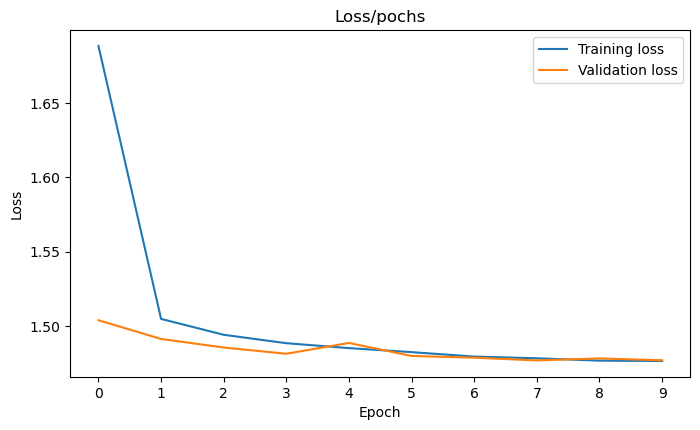

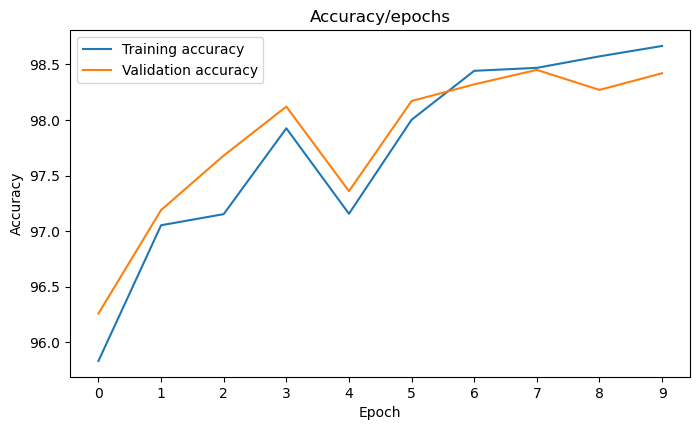

In [384]:
model = Model(n_classes).to(device)
criterion_use = nn.CrossEntropyLoss()
optimizer_use = torch.optim.Adam(model.parameters(), lr=learning_rate)

trained_model = train_loop(model=model, criterion=criterion_use, optimizer=optimizer_use,
                   num_epochs=epochs, dataloaders=[train_loader, test_loader],
                   dataset_sizes=dataset_sizes, device=device)

In [385]:
test_accuracy(train_loader, model, True)
test_accuracy(test_loader, model, False)


Model Predicted 59199 correctly out of 60000 from training dataset, Accuracy: 98.67
Model Predicted 9842 correctly out of 10000 from testing dataset, Accuracy: 98.42


In [386]:
model_input = torch.randn(batch_size, 1, 28, 28, requires_grad=True, device=device)
if batch_size < 500:
    print('up')
    torch.onnx.export(model, model_input, "KN-311_Tkachuk_Orest_up.onnx", export_params=True)
else:
    print('down')
    torch.onnx.export(model, model_input, "KN-311_Tkachuk_Orest.onnx", export_params=True)

up


predicted: 4
real: 9
abs error: 0.9999984


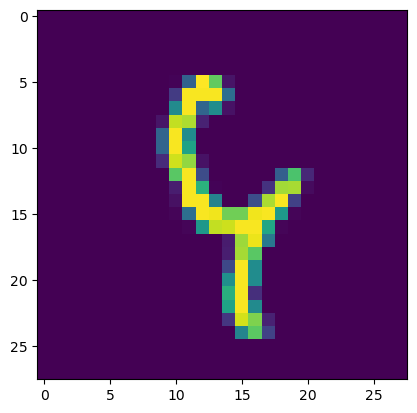

predicted: 8
real: 3
abs error: 0.99999785


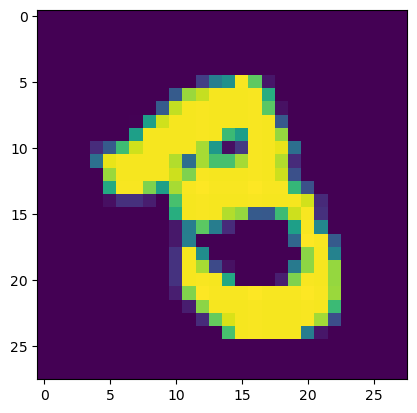

predicted: 6
real: 5
abs error: 0.9999976


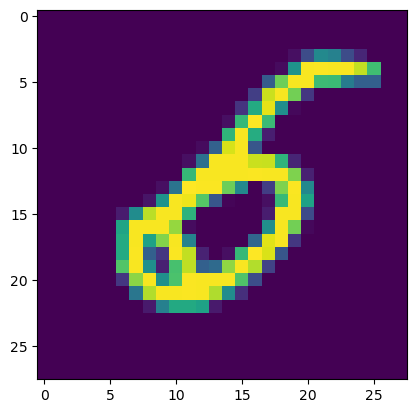

predicted: 2
real: 7
abs error: 0.9999929


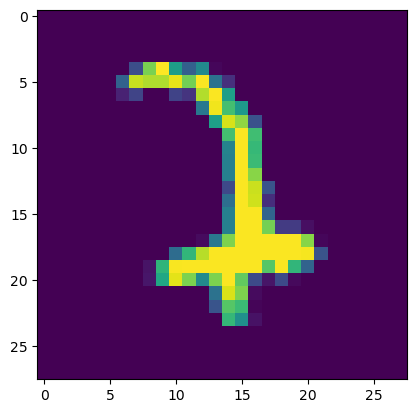

predicted: 2
real: 3
abs error: 0.99998313


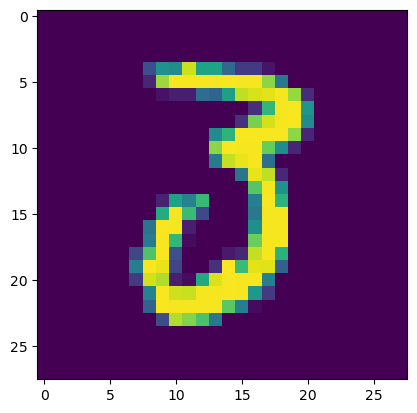

predicted: 6
real: 1
abs error: 0.9999647


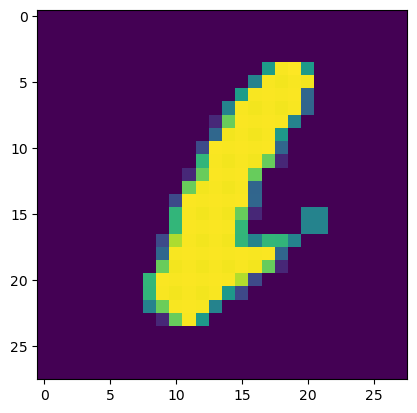

predicted: 8
real: 9
abs error: 0.9999204


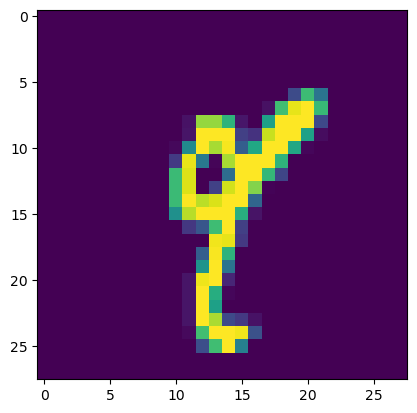

predicted: 2
real: 3
abs error: 0.9999133


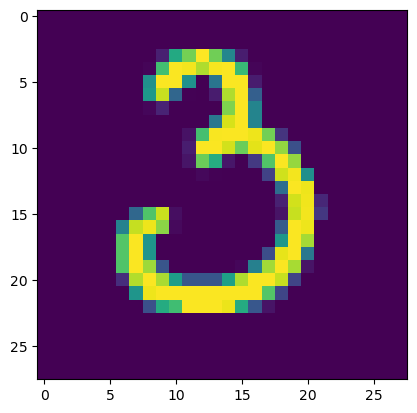

predicted: 6
real: 0
abs error: 0.99982834


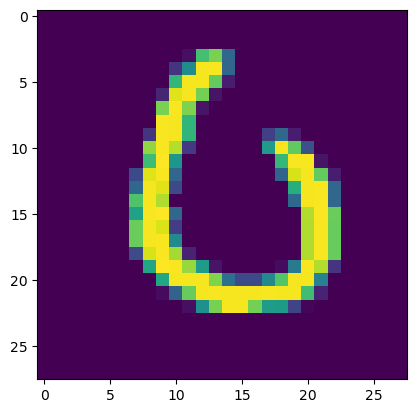

predicted: 3
real: 5
abs error: 0.9998175


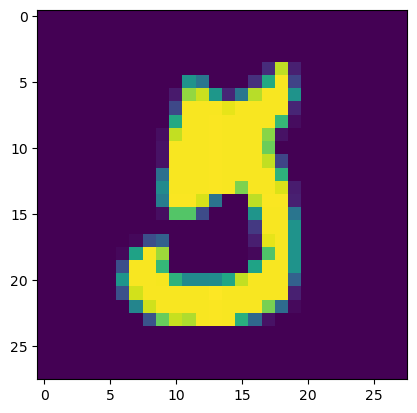

In [387]:
top_errors(train_loader, model)

In [388]:
import onnxruntime
if batch_size < 500:
    ort_session = onnxruntime.InferenceSession("KN-311_Tkachuk_Orest_up.onnx")
else:
    ort_session = onnxruntime.InferenceSession("KN-311_Tkachuk_Orest.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
print("Exported model has been tested with ONNXRuntime")

Exported model has been tested with ONNXRuntime


In [389]:
model.eval()
for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = outputs.max(1)
        
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputs)}
        ort_outs = ort_session.run(None, ort_inputs)
        try:
            np.testing.assert_allclose(to_numpy(outputs), ort_outs[0], rtol=1e-03, atol=1e-05)
            print('Mismatched elements: 0 (0%)')
        except Exception as exc:
            print(exc)

Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: 0 (0%)
Mismatched elements: